In [779]:
# Import Python Libraries
import pickle
import h5py
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import copy
from collections import OrderedDict
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [784]:
savename = 'LAT-2020_LON-180180m0hr'
#savename = 'LAT-2020_LON-180180rand'
savepath = '/avalanche/pmarin/INCUS/IMERG-CT/EOF_Plots/'
with open("/avalanche/pmarin/INCUS/IMERG-CT/pickle/IMERG-CT_ERA5_"+savename+".p", "rb") as input_file:
    data = pickle.load(input_file)

In [785]:
# Remove any row that has a NAN
data_cln = data.dropna(axis=0)
print((len(data)-len(data_cln))/len(data)*100)
print(len(data_cln))

11.238462969258102
138389


In [754]:
for col in data.columns:
    print(col)

CS_id
CS_year
CS_month
CS_day
CS_hour
CS_life
frac_ocean
max_lat
min_lat
max_lon
min_lon
minCTT_MERGED
CS_minminCTT_MERGED
maxP
CS_maxmaxp
area
area_low
lati
loni
llws
mlws
llsh
mlsh
mllr
mucape
mlcin
fl


In [755]:
#data_cln = data_cln[data_cln['CS_minminCTT_MERGED'] < 200]

In [756]:
# Check data by month and how much is removed by month -- i.e., any biases?
data_mo = OrderedDict()
len_dm = np.zeros(12)
data_cln_mo = OrderedDict()
len_cdm = np.zeros(12)
for i in np.arange(0,12):
    data_mo[i+1] = data[data['CS_month'] == i+1]
    len_dm[i] = len(data_mo[i+1])
    data_cln_mo[i+1] = data_cln[data_cln['CS_month'] == i+1]
    len_cdm[i] = len(data_cln_mo[i+1])

In [757]:
# Prepare data for covariance matrix
# Remove unncessary columns in data
nec_varnames = ['llws','mlws','llsh','mlsh','mllr','mucape','mlcin','fl']
data_cln_abr = data_cln[nec_varnames]

# Multiple lapse rates by -1 to make positive, and easier to interpret for EOFs
data_cln_abr['mllr'] = data_cln_abr['mllr'].apply(lambda x: x*-1)
#data_cln_abr['mlsh'] = np.abs(data_cln_abr['mlsh'])

print(data_cln_abr)

           llws     mlws     llsh    mlsh    mllr       mucape       mlcin  \
0        4.1673  12.8524  12.7209  5.1133  5.8178   818.239624  137.259094   
10       3.3566   2.0792  14.5832  5.4245  6.1685  2266.550781  113.988403   
25       0.7721   3.5082  13.5898  5.2709  5.5326    91.763000  130.026199   
48       3.7906   4.7234  12.1320  3.5584  5.5215   493.087799   78.098099   
128      5.7100   8.0917  11.9056  3.6042  5.8083   392.893097   91.282303   
...         ...      ...      ...     ...     ...          ...         ...   
1244339  6.1639   7.9075  12.8944  4.6593  5.4424   192.487198  241.084793   
1244342  4.0875   5.8024  11.3496  3.9292  5.6029   102.080597  143.439194   
1244348  1.9182   8.6056  13.4633  2.5718  5.8169  1644.666992   86.887497   
1244362  3.2132   5.4898  13.3959  5.0380  5.6428   751.959229    2.426300   
1244377  9.2373   8.0466  13.9004  4.0987  5.9118  1311.911377   32.991001   

                  fl  
0        4418.001953  
10       3915.845

/tmp/ipykernel_14727/560269584.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cln_abr['mllr'] = data_cln_abr['mllr'].apply(lambda x: x*-1)


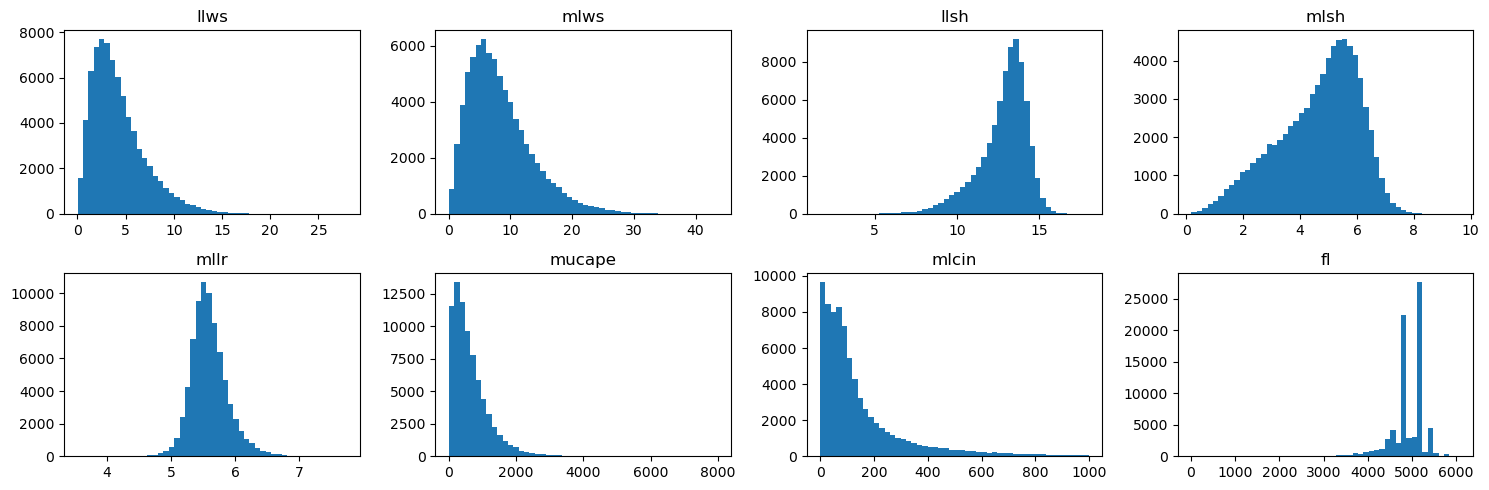

In [758]:
nbins = 50
fig,ax = plt.subplots(2,4,figsize=[15,5])
cnt = 0 
for i in np.arange(0,2):
    for j in np.arange(0,4):
        ax[i,j].hist(data_cln_abr[nec_varnames[cnt]],bins=nbins)
        ax[i,j].set_title(nec_varnames[cnt])
        cnt = cnt + 1
plt.tight_layout()
plt.savefig(savepath+'Histograms_'+savename+'.png')

In [759]:
# Standardize and Normalize Each Column Variable
data_n = pd.DataFrame()
data_ns = pd.DataFrame()

for v in np.arange(0,len(nec_varnames)):
    cname = nec_varnames[v]
    data_n[cname] = (data_cln_abr[cname]-data_cln_abr[cname].mean())
    data_ns[cname] = (data_cln_abr[cname]-data_cln_abr[cname].mean())/data_cln_abr[cname].std()

In [760]:
# Create Covariance Matrix (C)
data_len = np.shape(data_ns)[0]
C = (1/data_len) * np.dot(np.transpose(data_ns.values),data_ns.values)

In [761]:
# Calculate Eigenvectors and Eigenvalues from covariance matrix
[L,E] = np.linalg.eig(C) # Eigenvalues = L, Eigenvector Matrix E

# get Eigenvalues and resort from largest to smallest
lamb = np.array(L)

In [762]:
# Check eigenvalue math
check1=np.dot(C,E) #see matlab code (https://www.mathworks.com/help/matlab/ref/eig.html A*V = V*D)
check2=np.dot(E,np.diag(L))
check3=check1-check2 # Check 3 should be ~0 matrix 

In [763]:
print(E)
print(np.shape(E))

[[-1.83980733e-01 -2.11009429e-01  2.94010682e-02  2.36340574e-01
  -2.71797811e-01  4.90100870e-01  6.95612660e-01  2.58756518e-01]
 [-2.10853622e-01  8.86902816e-02 -5.98543928e-02 -5.10378314e-02
   2.10584241e-01 -6.84293750e-01  6.26439529e-01 -1.90937773e-01]
 [ 5.29448840e-01 -2.61584267e-01 -6.79008896e-01  2.45275197e-01
   3.39134084e-01  1.94470766e-02  9.88758295e-02  6.98430285e-02]
 [ 4.69329013e-01 -3.33975051e-01  5.76034703e-01 -3.12729319e-01
   3.59474081e-01  1.49084420e-01  2.15271095e-01 -2.01955228e-01]
 [-3.93137686e-01 -4.75267374e-01  2.42745085e-01  5.90447180e-01
   3.81106378e-01 -1.04642111e-01 -2.36259355e-01 -3.29189866e-04]
 [ 7.22616697e-03 -5.58350965e-01 -1.69091996e-02 -3.62358192e-01
  -2.80799055e-01 -3.80196673e-01 -9.71386728e-02  5.69007083e-01]
 [-5.04495987e-01 -8.03909208e-02 -3.02311413e-01 -5.41249704e-01
   4.90603368e-01  3.35082918e-01 -1.91491267e-02  3.65889434e-02]
 [ 1.09454946e-01  4.72806319e-01  2.28211922e-01  1.03422188e-01
   

In [764]:
lamb_sort = copy.deepcopy(lamb)

In [765]:
sort_idx = np.array(lamb_sort.argsort(axis=0))
lamb_sort.sort(axis=0)

sort_idx = list(reversed(sort_idx))
lamb_sort = np.array(list(reversed(lamb_sort)))

In [766]:
E_sort = E[:,sort_idx]

In [767]:
# Add code to check that A*V = V*D per maTLAB eig code


In [768]:
var_exp_sort = np.array(lamb_sort)/np.sum(lamb_sort)
print(var_exp_sort)

[0.30416959 0.17865946 0.13412937 0.12592618 0.1053897  0.07352929
 0.04730446 0.03089196]


In [769]:
d_lamb = lamb_sort*np.sqrt(2/data_len)
d_var_exp_sort = var_exp_sort*np.sqrt(2/data_len)

In [770]:
np.sum(var_exp_sort[0:6])

0.9218035896450006

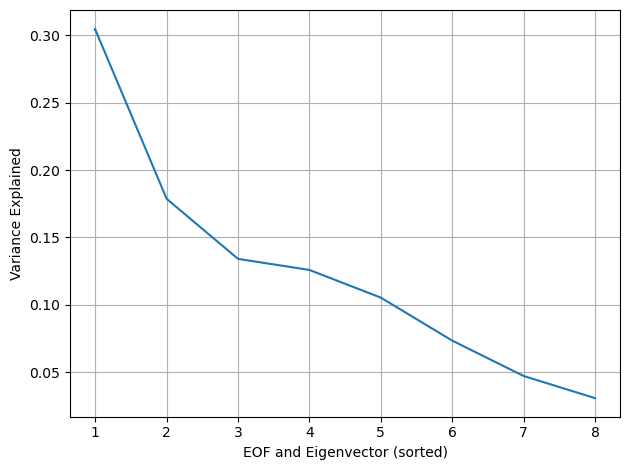

In [771]:
# Plot Variance Explained
fig,ax = plt.subplots(1,1)
#ax[0].errorbar(np.arange(0,len(lamb_sort)),lamb_sort,xerr=None,yerr=d_lamb/2)
#ax[0].set_ylabel('Eigenvalue')
#ax[0].set_xlabel('EOF and Eigenvector (sorted)')
ax.errorbar(np.arange(1,len(lamb_sort)+1),var_exp_sort,xerr=None,yerr=d_var_exp_sort/2)
ax.set_ylabel('Variance Explained')
ax.set_xlabel('EOF and Eigenvector (sorted)')
ax.grid()
plt.tight_layout()
plt.savefig(savepath+'Variance_Explained_'+savename+'.png')

/tmp/ipykernel_14727/3171103813.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i,j].set_xticklabels(nec_varnames)


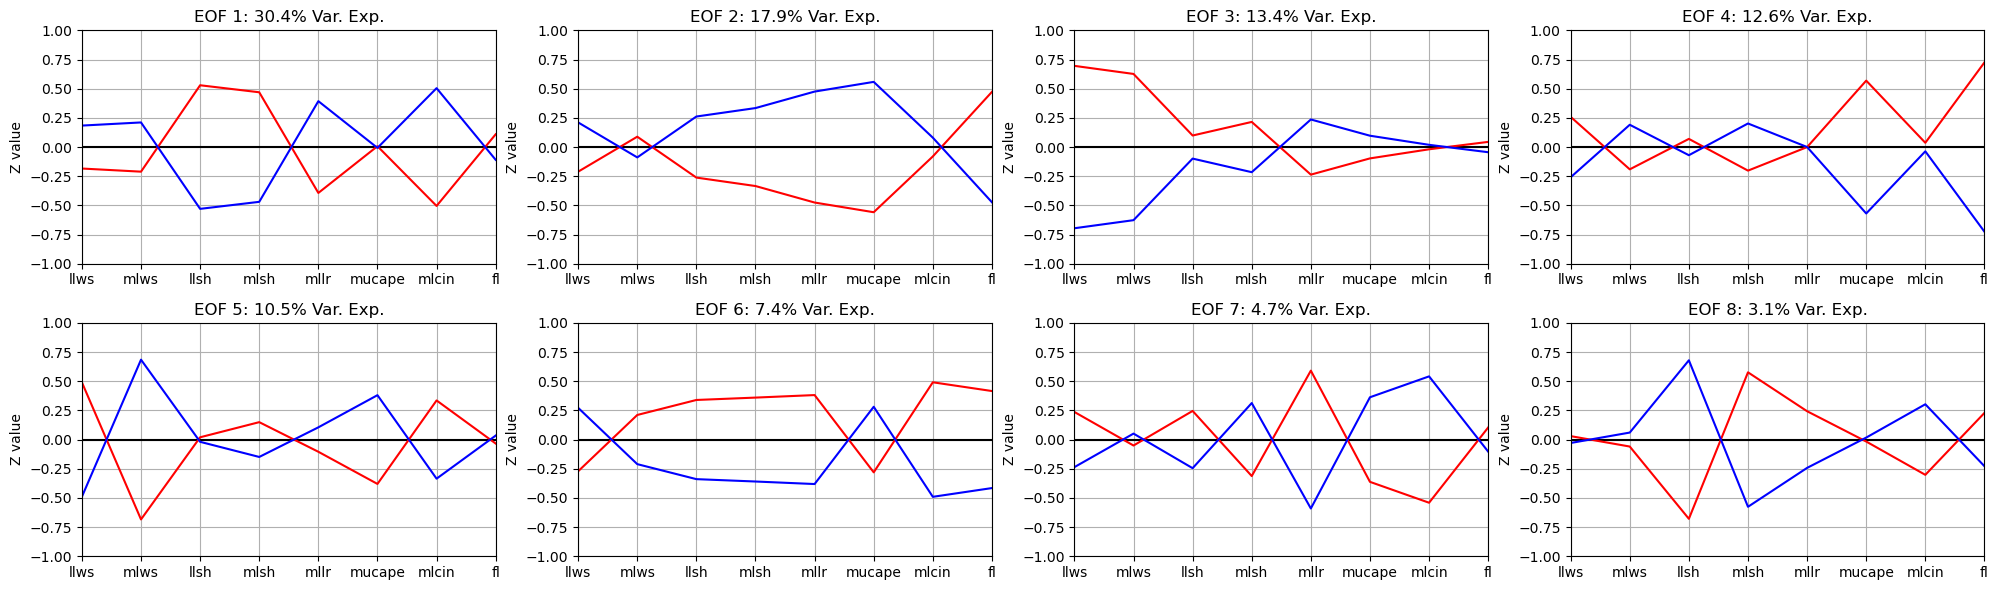

In [772]:
#Plot EOFs
fig,ax = plt.subplots(2,4,figsize=[20,6])
cnt = 0
for i in np.arange(0,2):
    for j in np.arange(0,4):
        ax[i,j].plot([0,len(lamb_sort)],[0,0],'-k')
        ax[i,j].plot(np.arange(0,len(lamb_sort)),E_sort[:,cnt],'-r')
        ax[i,j].plot(np.arange(0,len(lamb_sort)),E_sort[:,cnt]*-1,'-b')
#        ax[i,j].set_xticklabels(np.insert(nec_varnames,0,''))
        ax[i,j].set_xticklabels(nec_varnames)
        ax[i,j].set_ylabel('Z value')
        ax[i,j].set_title('EOF '+str(cnt+1)+': '+str(np.round(var_exp_sort[cnt]*100,1))+'% Var. Exp.')
        ax[i,j].set_ylim([-1,1])        
        ax[i,j].set_xlim([0,len(lamb_sort)-1])        
        ax[i,j].grid()
        cnt = cnt+1
plt.tight_layout()
plt.savefig(savepath+'EOF_Modes_'+savename+'.png')

In [773]:
np.sum(var_exp_sort[0:6])

0.9218035896450006

In [774]:
# Calculate Principle Components of the Data
Z = np.dot(data_ns,E_sort) # how much each datapoint looks like each eigenvector

zs = OrderedDict()
z_ns = OrderedDict()
for i in np.arange(0,len(lamb_sort)):
    zs[i] = Z[:,i];
    z_ns[i] = (zs[i]-np.mean(zs[i]))/np.std(zs[i])

In [775]:
len(z_ns[i])

76304

In [776]:

d = OrderedDict() # EOFs in physical snitss
ds = OrderedDict() # EOFs in standardized physical units
# Calculate EOFs in physical units
for i in np.arange(0,len(lamb_sort)):
    d[i] = (1/data_len)*np.dot(np.transpose(z_ns[i]),data_n)
    ds[i] = (1/data_len)*np.dot(np.transpose(z_ns[i]),data_ns)
    

In [777]:
with open('/avalanche/pmarin/INCUS/IMERG-CT/pickle/EOF_'+savename+'.p', 'wb') as handle:
    pickle.dump([lamb_sort,E_sort,var_exp_sort,d,ds], handle, protocol=pickle.HIGHEST_PROTOCOL)

/tmp/ipykernel_14727/3723130284.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i,j].set_xticklabels(nec_varnames)
/tmp/ipykernel_14727/3723130284.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i,j].set_xticklabels(nec_varnames)


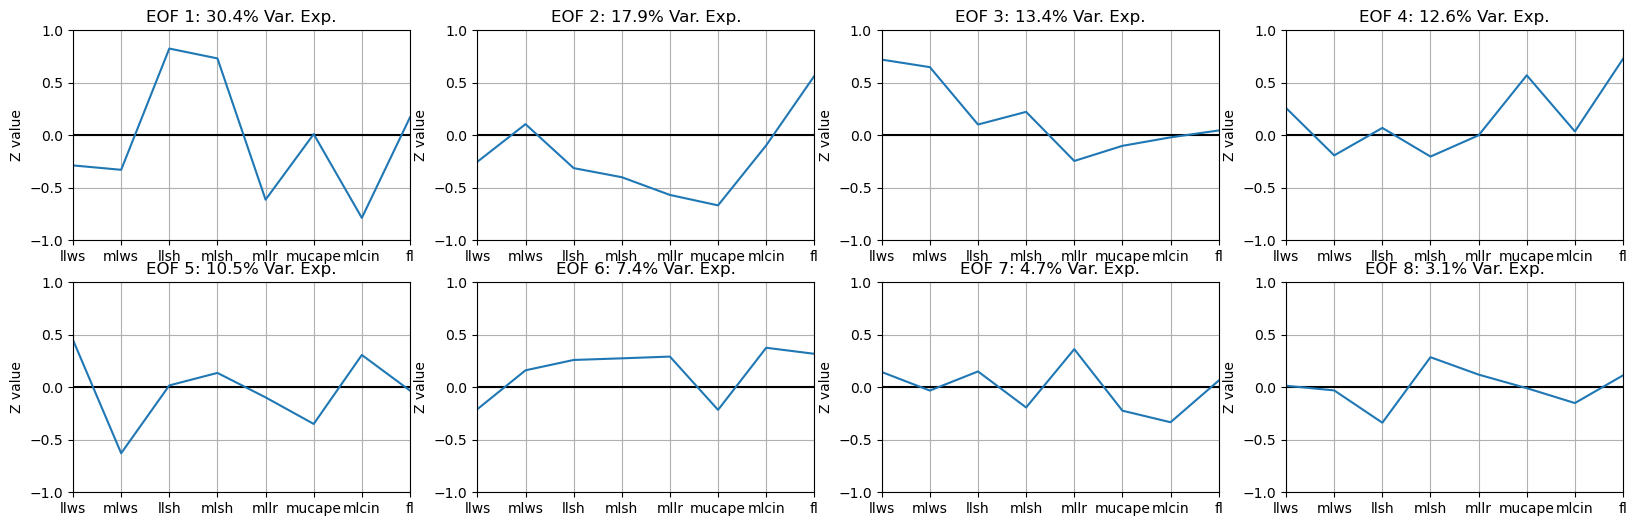

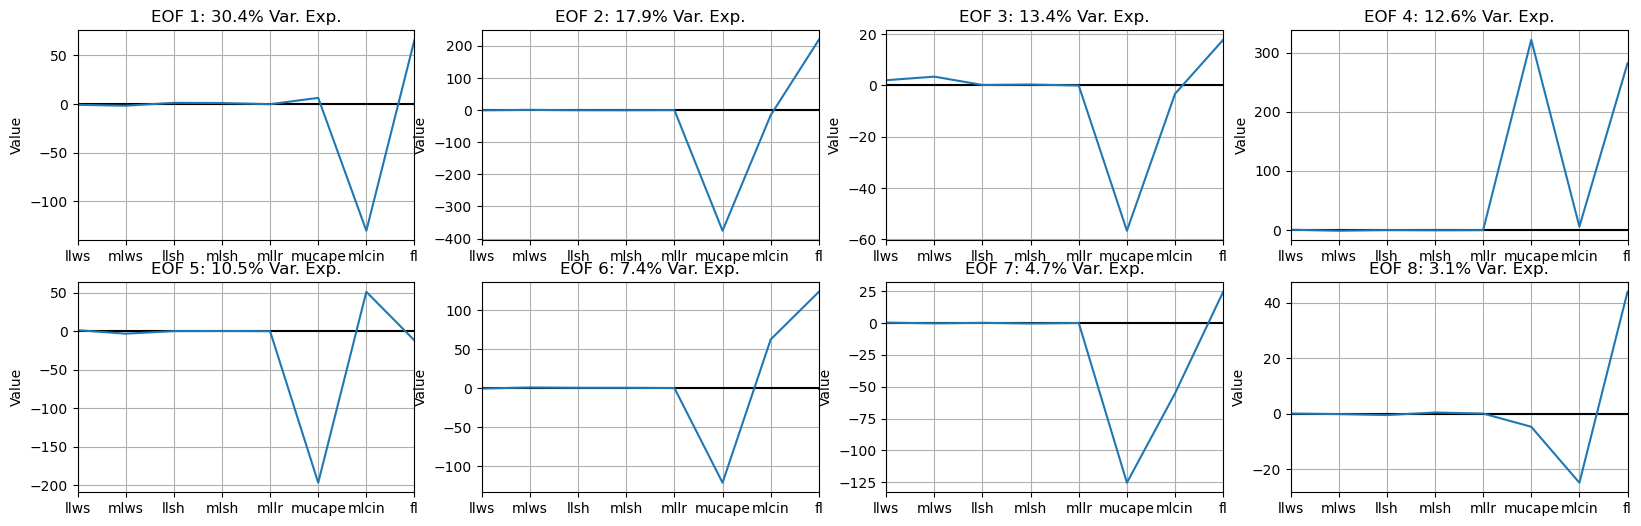

In [778]:
# Plot EOFs in physical Units (standardized)
fig,ax = plt.subplots(2,4,figsize=[20,6])
cnt = 0
for i in np.arange(0,2):
    for j in np.arange(0,4):
        ax[i,j].plot([0,len(lamb_sort)],[0,0],'-k')
        ax[i,j].plot(np.arange(0,len(lamb_sort)),ds[cnt])
#        ax[i,j].set_xticklabels(np.insert(nec_varnames,0,''))
        ax[i,j].set_xticklabels(nec_varnames)
        ax[i,j].set_ylabel('Z value')
        ax[i,j].set_title('EOF '+str(cnt+1)+': '+str(np.round(var_exp_sort[cnt]*100,1))+'% Var. Exp.')
        ax[i,j].set_xlim([0,len(lamb_sort)-1])        
        ax[i,j].set_ylim([-1,1])        
        ax[i,j].grid()
        cnt = cnt+1
        
# Plot EOFs in physical Units
fig,ax = plt.subplots(2,4,figsize=[20,6])
cnt = 0
for i in np.arange(0,2):
    for j in np.arange(0,4):
        ax[i,j].plot([0,len(lamb_sort)],[0,0],'-k')
        ax[i,j].plot(np.arange(0,len(lamb_sort)),d[cnt])
#        ax[i,j].set_xticklabels(np.insert(nec_varnames,0,''))
        ax[i,j].set_xticklabels(nec_varnames)
        ax[i,j].set_ylabel('Value')
        ax[i,j].set_title('EOF '+str(cnt+1)+': '+str(np.round(var_exp_sort[cnt]*100,1))+'% Var. Exp.')
        ax[i,j].set_xlim([0,len(lamb_sort)-1])        
#        ax[i,j].set_ylim([-1,1])        
        ax[i,j].grid()
        cnt = cnt+1

/home/pmarin/miniconda3/envs/basic/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/pmarin/miniconda3/envs/basic/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


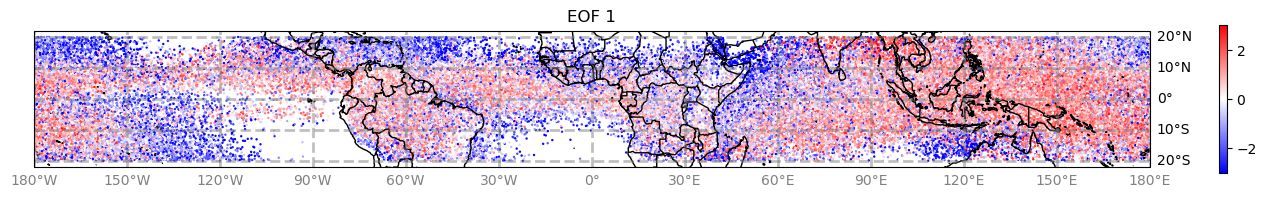

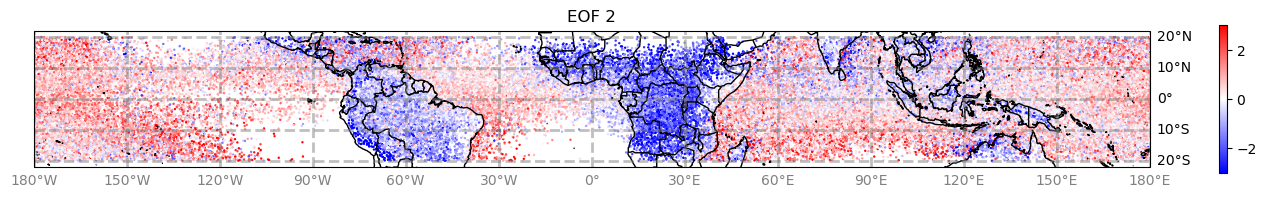

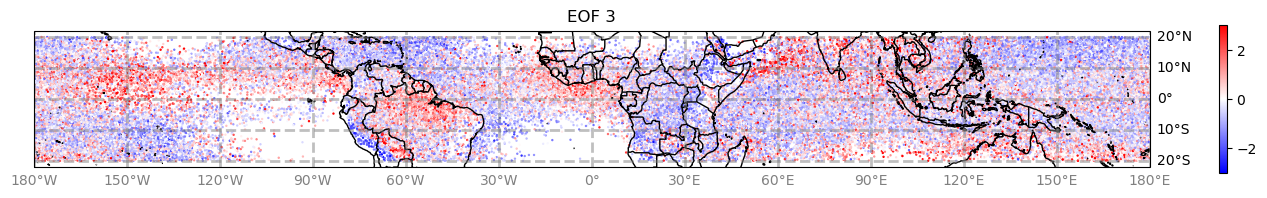

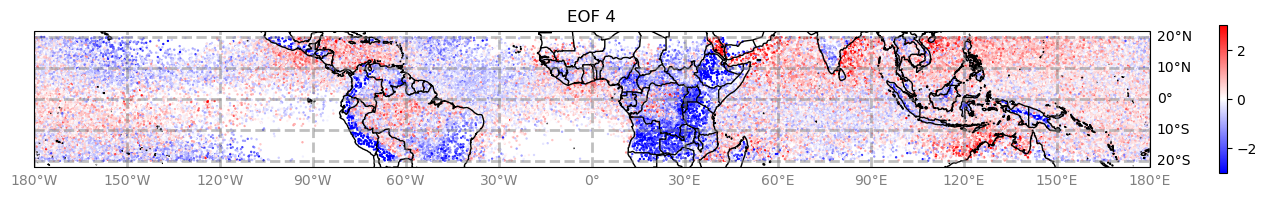

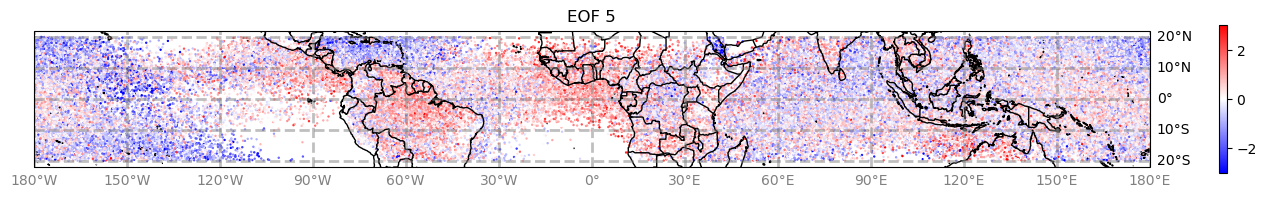

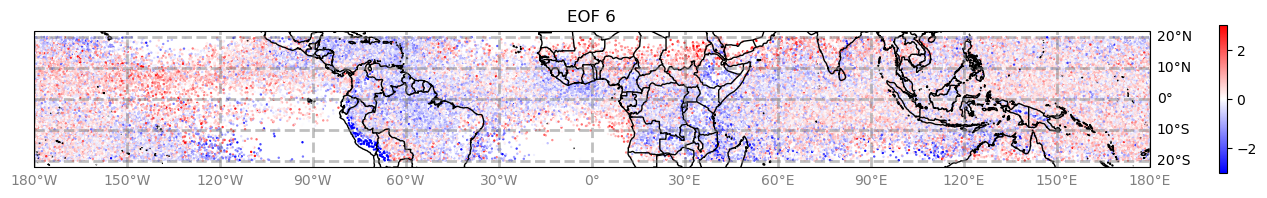

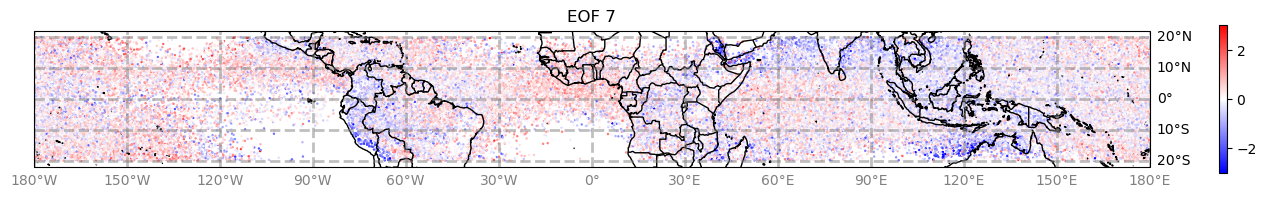

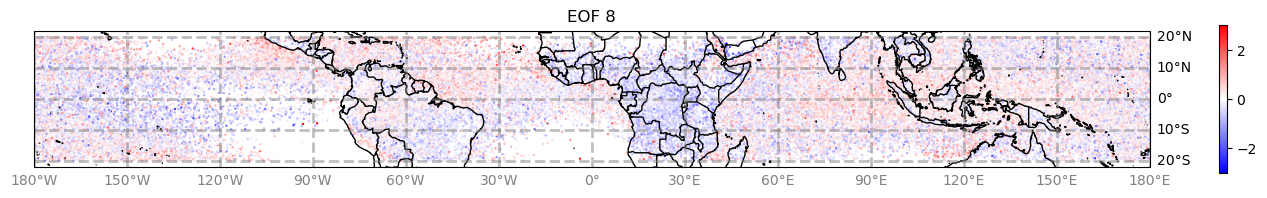

In [676]:
cnt = 0
for j in np.arange(0,8):
    fig = plt.figure(figsize=[18,18])
    ax = fig.add_subplot(8, 1, cnt+1, projection=ccrs.PlateCarree())

    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = False
    #gl.xlines = False
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180.1,30))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.ylocator = mticker.FixedLocator(np.arange(-20,20.1,10))
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'color': 'gray'}
    gl.xlabel_style = {'color': 'gray'}        

    a = ax.scatter(data_cln['loni'].values,data_cln['lati'].values,c=zs[cnt],s=0.5,vmin=-3,vmax=3,cmap=plt.cm.bwr)
    ax.set_xlim([-180,180])
    ax.set_ylim([-22,22])
    ax.set_title('EOF '+str(cnt+1))
    plt.colorbar(a,ax=ax)

    cnt = cnt + 1
    plt.savefig(savepath+'EOF'+str(j+1)+'_ZScore_Maps_'+savename+'.png')
#adfggds
        

Text(0.5, 1.0, 'Correlation Coefficient (r) = -0.002')

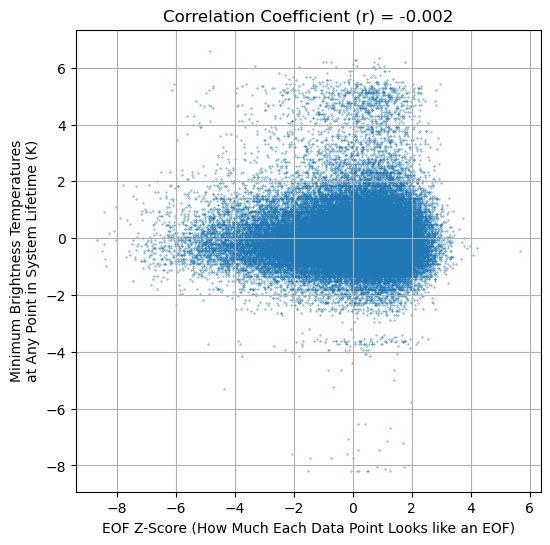

In [677]:
eof_id = 0
plt.figure(figsize=[6,6])
plt.scatter(zs[eof_id],(data_cln['CS_minminCTT_MERGED']-np.mean(data_cln['CS_minminCTT_MERGED']))/np.std(data_cln['CS_minminCTT_MERGED']),s=0.1)
plt.grid()
plt.xlabel('EOF Z-Score (How Much Each Data Point Looks like an EOF)')
plt.ylabel('Minimum Brightness Temperatures\nat Any Point in System Lifetime (K)')
plt.title('Correlation Coefficient (r) = '+str(np.round(np.corrcoef(zs[eof_id],data_cln['CS_minminCTT_MERGED'])[0,1],3)))


Text(0.5, 1.0, 'Correlation Coefficient (r) = 0.005')

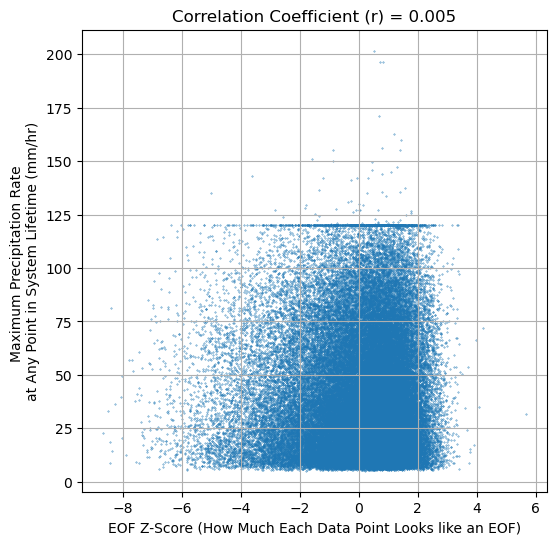

In [678]:
eof_id = 0
plt.figure(figsize=[6,6])
plt.scatter(zs[eof_id],data_cln['CS_maxmaxp'],s=0.1)
np.corrcoef(zs[eof_id],data_cln['CS_maxmaxp'])
plt.grid()
plt.xlabel('EOF Z-Score (How Much Each Data Point Looks like an EOF)')
plt.ylabel('Maximum Precipitation Rate \nat Any Point in System Lifetime (mm/hr)')
plt.title('Correlation Coefficient (r) = '+str(np.round(np.corrcoef(zs[eof_id],data_cln['CS_maxmaxp'])[0,1],3)))

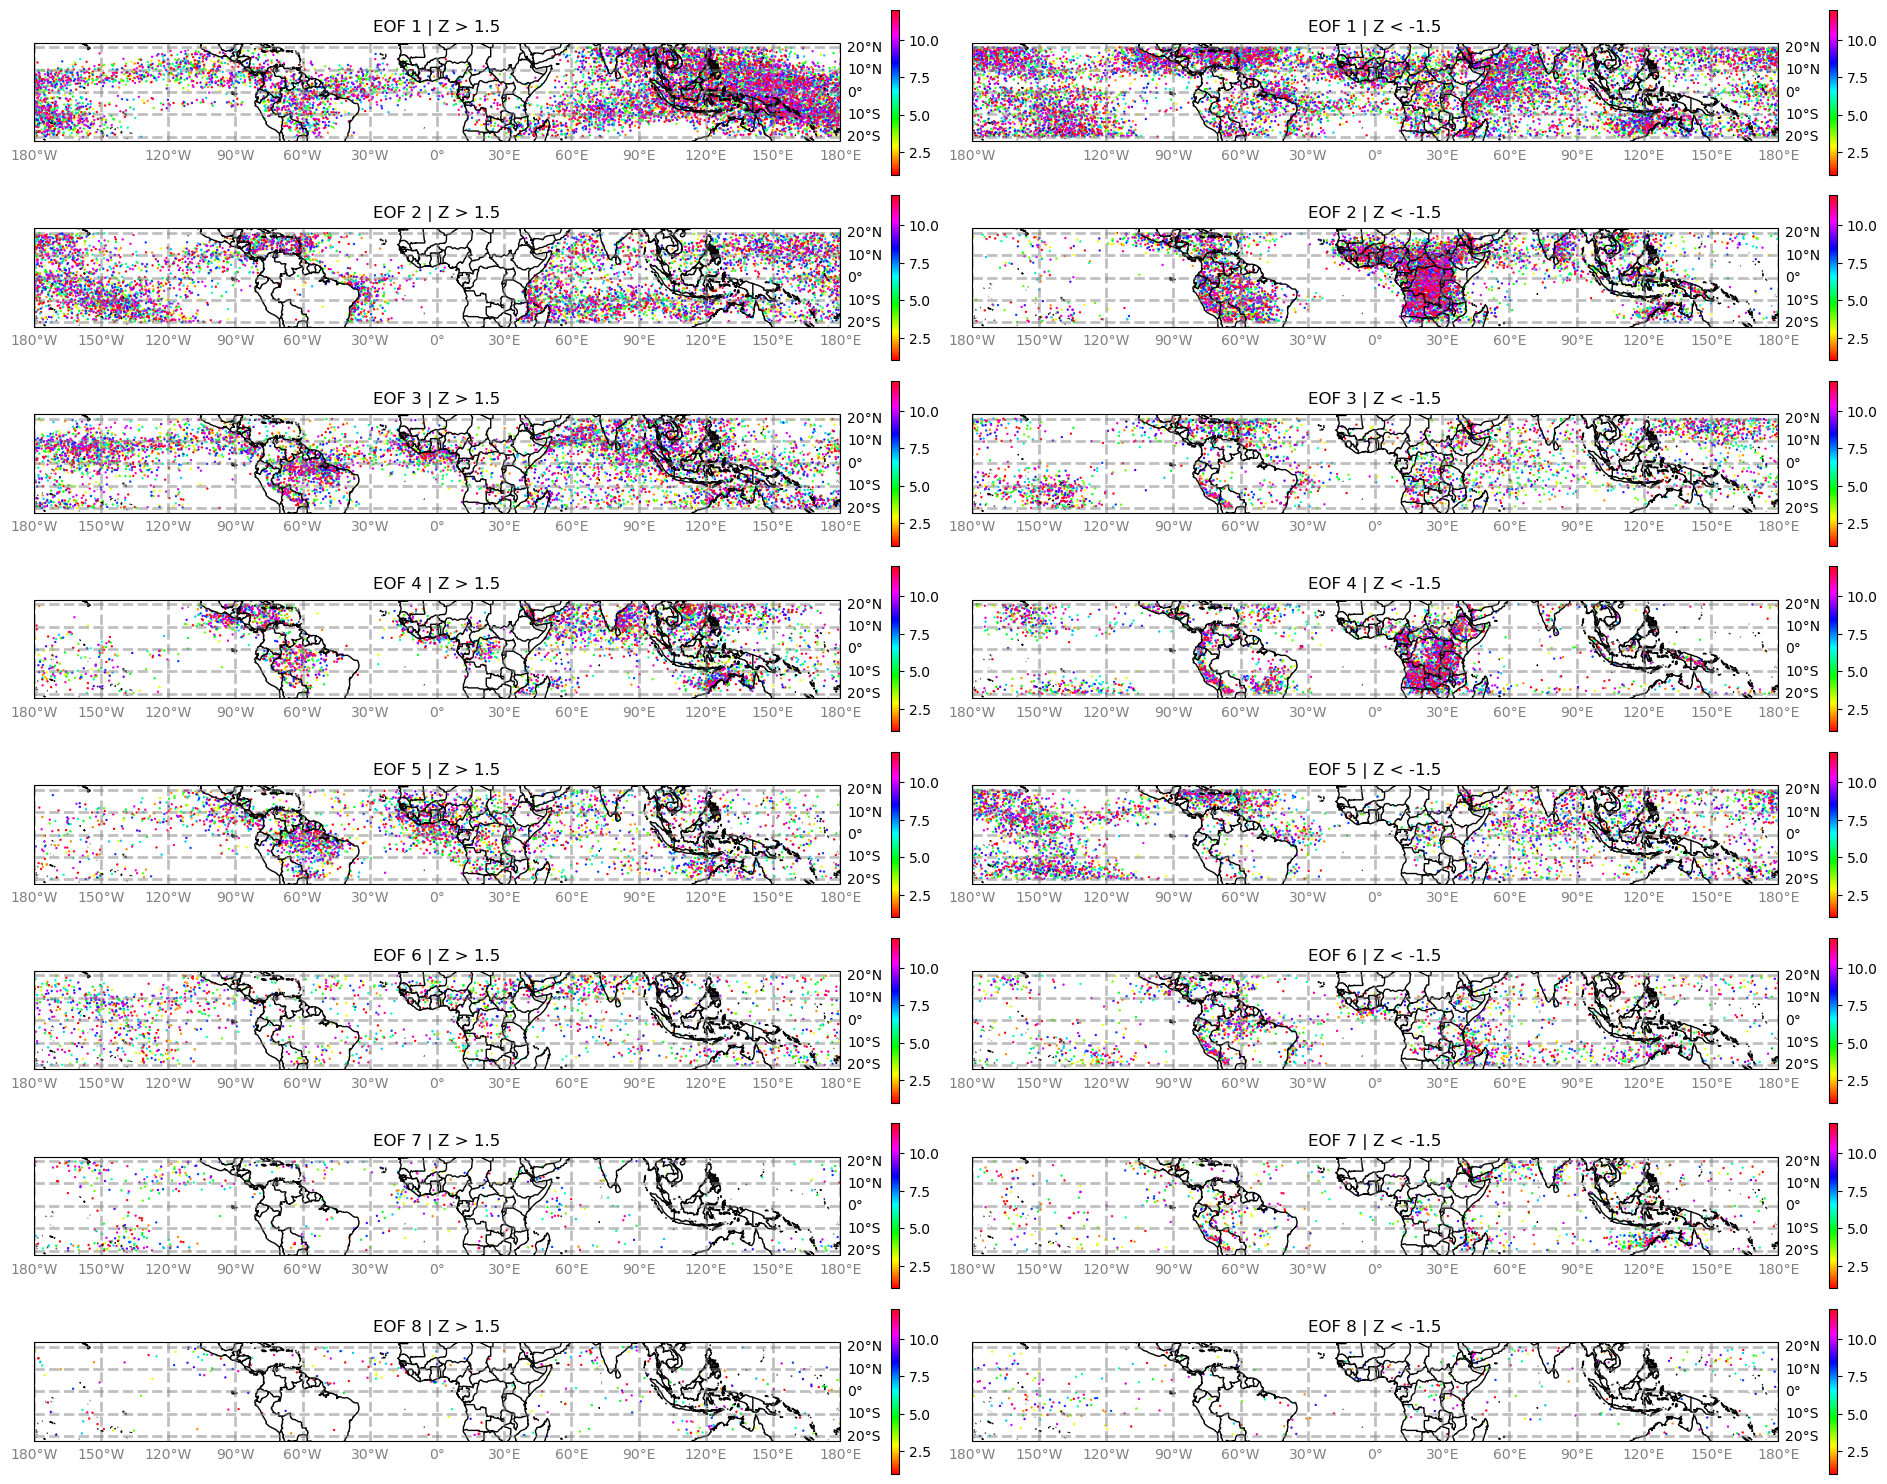

In [679]:
# Zscores by month
cnt = 0
eofcnt = 0
fig = plt.figure(figsize=[20,15])
for j in np.arange(0,8):

    id_gtp1 = np.where(zs[j] > 1.5)[0]
    lon_gtp1 = data_cln['loni'].values[id_gtp1]
    lat_gtp1 = data_cln['lati'].values[id_gtp1]
    mon_gtp1 = data_cln['CS_month'].values[id_gtp1]
    zs_gtp1 = zs[j][id_gtp1]
      
    id_ltn1 = np.where(zs[j] < -1.5)[0]
    lon_ltn1 = data_cln['loni'].values[id_ltn1]
    lat_ltn1 = data_cln['lati'].values[id_ltn1]
    mon_ltn1 = data_cln['CS_month'].values[id_ltn1]
    zs_ltn1 = zs[j][id_ltn1]
    
    ax = fig.add_subplot(8, 2, cnt+1, projection=ccrs.PlateCarree())

    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = False
    #gl.xlines = False
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180.1,30))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.ylocator = mticker.FixedLocator(np.arange(-20,20.1,10))
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'color': 'gray'}
    gl.xlabel_style = {'color': 'gray'}        

    a = ax.scatter(lon_gtp1,lat_gtp1,c=mon_gtp1,s=0.5,vmin=1,vmax=12,cmap=plt.cm.hsv)
    plt.colorbar(a,ax=ax)
    ax.set_xlim([-180,180])
    ax.set_ylim([-22,22])
    ax.set_title('EOF '+str(eofcnt+1)+' | Z > 1.5')
    
    
    cnt = cnt + 1

    
    ax = fig.add_subplot(8, 2, cnt+1, projection=ccrs.PlateCarree())

    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = False
    #gl.xlines = False
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180.1,30))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.ylocator = mticker.FixedLocator(np.arange(-20,20.1,10))
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'color': 'gray'}
    gl.xlabel_style = {'color': 'gray'}        

    a = ax.scatter(lon_ltn1,lat_ltn1,c=mon_ltn1,s=0.5,vmin=1,vmax=12,cmap=plt.cm.hsv)
    plt.colorbar(a,ax=ax)
    ax.set_xlim([-180,180])
    ax.set_ylim([-22,22])
    ax.set_title('EOF '+str(eofcnt+1)+' | Z < -1.5')
    cnt = cnt + 1    
    
    eofcnt = eofcnt +1
    plt.tight_layout()
    plt.savefig(savepath+'EOF'+str(j+1)+'_ZScore_Maps_by_Month_'+savename+'.png')

    
    
    
    #adfggds
        

In [632]:
id_gt1 = np.where(zs[0] > 1)[0]
